En este cuaderno vamos a ver: 

* Un ejemplo de red neuronal
* El concepto de tensor y operaciones con tensores
* Cómo las redes neuronales aprenden a través del algoritmo de retropropagación y el descenso por gradiente



This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Los bloques de construcción matemáticos de las redes neuronales

Vamos a hacer el típico ejemplo de clasificación de dígitos implementando una red neuronal básica en Keras. Para ello utilizaremos la famosa base de datos MNIST que contiene imágenes en escala de gris de dígitos escritos a mano (28x28 píxeles) que se agrupan en 10 categorías. 

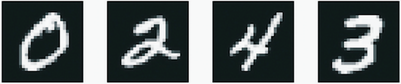

## Un primer vistazo a una red neuronal

**Cargando la base de datos MNIST en Keras**

El conjunto de datos MNIST viene precargado en Keras como un `NumPy array`

In [38]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Veamos las características de los datos de entrenamiento:

In [39]:
train_images.shape

(60000, 28, 28)

In [40]:
len(train_labels)

60000

In [41]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Y los datos de test:

In [42]:
test_images.shape

(10000, 28, 28)

In [43]:
len(test_labels)

10000

In [44]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

**Arquitectura de la red**

El bloque principal para definir una red neuronal es la `capa` (`layer`). Podemos ver las capas como una forma de filtrado de datos donde estos se van transformando progresivamente. Cada capa extrae *representaciones* de los datos que se espera que sean significativas para el problema.

En este caso tenemos una secuencia de dos capas `densas` (`Dense`), que significa que están conectadas completamente (*densamente*). 

La última capa, es una capa de *clasificación softmax* con 10 salidas de probabilidades de pertenencia a cada clase (entre las 10 suman 1).

In [45]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

**La compilacion del modelo**

Para que podamos entrenar el modelo este debe *compilarse*, y para ello debemos elegir: 
* **optimizador**
* **función de pérdida** (*loss function*)
* **métricas de rendimiento**

In [46]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


**Preparación de los datos de imágenes**

Necesitamos transformar nuestra matriz de datos `(60000, 28, 28)` del tipo `uint8` en el intervalor `[0, 255]` a valores reales `float32` en `[0,1]` con una matriz de dimensiones `(60000, 28 * 28)`

> Bloque con sangría



In [47]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

Nuevo formato de las mastrices: 

In [48]:
train_images.shape

(60000, 784)

In [49]:
test_images.shape

(10000, 784)

**"Ajustando" el modelo**

Ya estamos listo para entrenar el modelo, que en Keras, como en muchos otros *framworks* se hace con el método `fit()`: *ajustamos* el modelo a los datos de entrenamiento.

Nota: El siguiente código tardará en ejecutarse unos segundos/minutos:

In [50]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 6s 13ms/step - loss: 0.2556 - accuracy: 0.9250
Epoch 2/5
469/469 [==============================] - 6s 12ms/step - loss: 0.1034 - accuracy: 0.9693
Epoch 3/5
469/469 [==============================] - 5s 12ms/step - loss: 0.0692 - accuracy: 0.9794
Epoch 4/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0490 - accuracy: 0.9850
Epoch 5/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0374 - accuracy: 0.9889


❓❓ ¿Sabrías interpretar las cantidades que se van imprimiendo? ❓❓

**Visualizar el modelo**

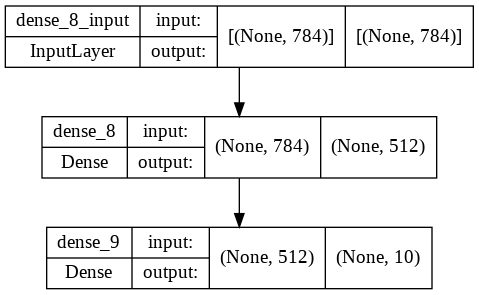

In [51]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [52]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               401920    
                                                                 
 dense_9 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
None


**Hacer predicciones con nuestro modelo**

Una vez el modelo ha sido ajustado/entrenado podemos utilizarlo para predecir las propbabilidades de nuevos dígitos que no fueron utilizados durante el entrenamiento y reservamos en el conjunto de *test*. 

En el siguente código cada posición `i` del vector de predicciones corresponde a la probabilidad de que la imagen `test_digits[0]` pertenezca a la clase `i`.

In [53]:
test_digits = test_images[0:10]
predictions = model.predict(test_digits)
predictions[0]

array([1.2818672e-09, 3.8062434e-10, 2.9666871e-06, 3.3875473e-05,
       1.2344000e-12, 3.9162693e-08, 1.2993882e-14, 9.9996257e-01,
       1.4055698e-07, 4.8115311e-07], dtype=float32)

Para este primer patrón de test, el índice `i` con mayor probabilidad, `0.99999106` para `7` en nuestro caso, es la clase estimada por nuestro modelo, por tanto debe ser un 7.

In [56]:
predictions[0].argmax()

7

In [55]:
predictions[0][7]

0.99996257

Podemos constrastar la preducción con la etiqueta del patrón:

In [57]:
test_labels[0]

7

**Evaluación del modelo**

Podemos calcular la precisión global media sobre todo el conjunto de *test*. En  este caso la precisión es ligeramente inferior a la de entrenamiento. 

In [58]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0638 - accuracy: 0.9805
test_acc: 0.9804999828338623


In [75]:
test_pred = model.predict(test_images)

In [76]:
test_pred = test_pred.argmax(axis=1)

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(test_labels, test_pred)

array([[ 968,    0,    2,    1,    0,    1,    3,    1,    4,    0],
       [   0, 1126,    4,    0,    0,    1,    2,    0,    2,    0],
       [   3,    1, 1015,    4,    1,    0,    2,    3,    3,    0],
       [   0,    0,    2,  999,    0,    2,    0,    3,    3,    1],
       [   2,    0,    5,    0,  957,    0,    3,    2,    1,   12],
       [   2,    0,    0,   11,    1,  868,    3,    0,    4,    3],
       [   3,    2,    2,    1,    2,    7,  936,    0,    5,    0],
       [   0,    4,   12,    2,    0,    0,    0, 1001,    5,    4],
       [   1,    0,    4,    5,    1,    4,    0,    3,  955,    1],
       [   1,    2,    0,    7,    3,    3,    0,    4,    9,  980]])

## Data representations for neural networks

### Scalars (rank-0 tensors)

In [ ]:
import numpy as np
x = np.array(12)
x

In [ ]:
x.ndim

### Vectors (rank-1 tensors)

In [ ]:
x = np.array([12, 3, 6, 14, 7])
x

In [ ]:
x.ndim

### Matrices (rank-2 tensors)

In [ ]:
x = np.array([[5, 78, 2, 34, 0],
              [6, 79, 3, 35, 1],
              [7, 80, 4, 36, 2]])
x.ndim

### Rank-3 and higher-rank tensors

In [ ]:
x = np.array([[[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]]])
x.ndim

### Key attributes

In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
train_images.ndim

In [ ]:
train_images.shape

In [ ]:
train_images.dtype

**Displaying the fourth digit**

In [ ]:
import matplotlib.pyplot as plt
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [ ]:
train_labels[4]

### Manipulating tensors in NumPy

In [ ]:
my_slice = train_images[10:100]
my_slice.shape

In [ ]:
my_slice = train_images[10:100, :, :]
my_slice.shape

In [ ]:
my_slice = train_images[10:100, 0:28, 0:28]
my_slice.shape

In [ ]:
my_slice = train_images[:, 14:, 14:]

In [ ]:
my_slice = train_images[:, 7:-7, 7:-7]

### The notion of data batches

In [ ]:
batch = train_images[:128]

In [ ]:
batch = train_images[128:256]

In [ ]:
n = 3
batch = train_images[128 * n:128 * (n + 1)]

### Real-world examples of data tensors

### Vector data

### Timeseries data or sequence data

### Image data

### Video data

## The gears of neural networks: tensor operations

### Element-wise operations

In [ ]:
def naive_relu(x):
    assert len(x.shape) == 2
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
    return x

In [ ]:
def naive_add(x, y):
    assert len(x.shape) == 2
    assert x.shape == y.shape
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
    return x

In [ ]:
import time

x = np.random.random((20, 100))
y = np.random.random((20, 100))

t0 = time.time()
for _ in range(1000):
    z = x + y
    z = np.maximum(z, 0.)
print("Took: {0:.2f} s".format(time.time() - t0))

In [ ]:
t0 = time.time()
for _ in range(1000):
    z = naive_add(x, y)
    z = naive_relu(z)
print("Took: {0:.2f} s".format(time.time() - t0))

### Broadcasting

In [ ]:
import numpy as np
X = np.random.random((32, 10))
y = np.random.random((10,))

In [ ]:
y = np.expand_dims(y, axis=0)

In [ ]:
Y = np.concatenate([y] * 32, axis=0)

In [ ]:
def naive_add_matrix_and_vector(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[j]
    return x

In [ ]:
import numpy as np
x = np.random.random((64, 3, 32, 10))
y = np.random.random((32, 10))
z = np.maximum(x, y)

### Tensor product

In [ ]:
x = np.random.random((32,))
y = np.random.random((32,))
z = np.dot(x, y)

In [ ]:
def naive_vector_dot(x, y):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]
    z = 0.
    for i in range(x.shape[0]):
        z += x[i] * y[i]
    return z

In [ ]:
def naive_matrix_vector_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i] += x[i, j] * y[j]
    return z

In [ ]:
def naive_matrix_vector_dot(x, y):
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        z[i] = naive_vector_dot(x[i, :], y)
    return z

In [ ]:
def naive_matrix_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 2
    assert x.shape[1] == y.shape[0]
    z = np.zeros((x.shape[0], y.shape[1]))
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            row_x = x[i, :]
            column_y = y[:, j]
            z[i, j] = naive_vector_dot(row_x, column_y)
    return z

### Tensor reshaping

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))

In [ ]:
x = np.array([[0., 1.],
             [2., 3.],
             [4., 5.]])
x.shape

In [ ]:
x = x.reshape((6, 1))
x

In [ ]:
x = np.zeros((300, 20))
x = np.transpose(x)
x.shape

### Geometric interpretation of tensor operations

### A geometric interpretation of deep learning

## The engine of neural networks: gradient-based optimization

### What's a derivative?

### Derivative of a tensor operation: the gradient

### Stochastic gradient descent

### Chaining derivatives: The Backpropagation algorithm

#### The chain rule

#### Automatic differentiation with computation graphs

#### The gradient tape in TensorFlow

In [ ]:
import tensorflow as tf
x = tf.Variable(0.)
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)

In [ ]:
x = tf.Variable(tf.random.uniform((2, 2)))
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)

In [ ]:
W = tf.Variable(tf.random.uniform((2, 2)))
b = tf.Variable(tf.zeros((2,)))
x = tf.random.uniform((2, 2))
with tf.GradientTape() as tape:
    y = tf.matmul(x, W) + b
grad_of_y_wrt_W_and_b = tape.gradient(y, [W, b])

## Looking back at our first example

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

### Reimplementing our first example from scratch in TensorFlow

#### A simple Dense class

In [ ]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

#### A simple Sequential class

In [ ]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

In [ ]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

#### A batch generator

In [ ]:
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

### Running one training step

In [ ]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

In [ ]:
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(g * learning_rate)

In [ ]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

### The full training loop

In [ ]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")

In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

### Evaluating the model

In [ ]:
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

## Summary